In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from argparse import Namespace
from logging import warning
import os.path as osp

from torch_geometric.graphgym.config import cfg, dump_cfg, set_cfg, load_cfg
from torch_geometric.graphgym.loader import create_loader
from torch_geometric.graphgym.model_builder import create_model
from torch_geometric.graphgym.loss import compute_loss
from graphgps.finetuning import load_pretrained_model_cfg, init_model_from_pretrained

/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

11.3
False
True


In [3]:
# CONFIGURATION

args = Namespace(
    cfg_file = 'configs/Small-experiment/PascalVOC-SP/GPS+SparseAttention.yaml',
    repeat = 1,
    mark_done = False,
    opts=[],
)

set_cfg(cfg)
load_cfg(cfg, args)
dump_cfg(cfg)

if hasattr(cfg, 'pretrained_dir'):
    warning.warn(f"cfg has pretrained_dir {cfg.pretrained_dir}, which we are not using")
cfg.pretrained.dir = 'results/PascalVOC-SP/GPS+SparseAttention/'   # None to use random initialization
if cfg.device == 'auto':
    cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {cfg.device}")

cfg = load_pretrained_model_cfg(cfg)

# Set Pytorch environment
torch.set_num_threads(cfg.num_threads)

Using device: cpu


In [4]:
# LOADER
loaders = create_loader()

loader = loaders[0]
split = 'test'

: 

In [ ]:

# MODEL
model = create_model()
if cfg.pretrained.dir:
    model = init_model_from_pretrained(
        model, cfg.pretrained.dir, freeze_main=False,
        reset_prediction_head=False, device=cfg.device
    )


model.eval()

GPSModel(
  (encoder): FeatureEncoder(
    (node_encoder): Concat2NodeEncoder(
      (encoder1): LinearNodeEncoder(
        (encoder): Linear(in_features=5, out_features=40, bias=True)
      )
      (encoder2): EquivStableLapPENodeEncoder(
        (linear_encoder_eigenvec): Linear(in_features=8, out_features=40, bias=True)
      )
    )
    (edge_encoder): LinearEdgeEncoder(
      (encoder): Linear(in_features=1, out_features=40, bias=True)
    )
  )
  (layers): Sequential(
    (0): GPSLayer(
      summary: dim_h=40, local_gnn_type=CustomGatedGCN, global_model_type=SparseAttention, heads=4
      (local_model): GatedGCNLayer()
      (self_attn): SparseAttention(
        (MQs): Linear(in_features=40, out_features=160, bias=True)
        (MKs): Linear(in_features=40, out_features=160, bias=True)
        (MVs): Linear(in_features=40, out_features=160, bias=True)
        (MO): Linear(in_features=160, out_features=40, bias=True)
      )
      (norm1_local): BatchNorm1d(40, eps=1e-05, momentu

In [19]:
print(len(loaders))
# print(len(loggers))
print(loaders[0].dataset.data.x.shape)
print(loaders[0].dataset.data.y.shape)
print(loaders[1].dataset.data.x.shape)
print(loaders[1].dataset.data.y.shape)
print(loaders[2].dataset.data.x.shape)
print(loaders[2].dataset.data.y.shape)

# find the difference between the two loaders
print(torch.all(loaders[0].dataset.data.x == loaders[2].dataset.data.x))
print(torch.all(loaders[0].dataset.data.y == loaders[2].dataset.data.y))


3


NameError: name 'loggers' is not defined

In [22]:
from graphgps.loss.subtoken_prediction_loss import subtoken_cross_entropy

def arxiv_cross_entropy(pred, true, split_idx):
    true = true.squeeze(-1)
    if pred.ndim > 1 and true.ndim == 1:
        pred_score = F.log_softmax(pred[split_idx], dim=-1)
        loss =  F.nll_loss(pred_score, true[split_idx])
    else:
        raise ValueError("In ogbn cross_entropy calculation dimensions did not match.")
    return loss, pred_score



loader = loaders[0]
split = 'test'

i = -1
for batch in loader:
    i += 1
    if i%20 == 0:
        print("processing batch", i)
    batch.split = split
    
    if cfg.gnn.head == 'inductive_edge':
        pred, true, extra_stats = model(batch)
    else:
        pred, true = model(batch)
        extra_stats = {}
    
    if cfg.dataset.name == 'ogbg-code2':
        loss, pred_score = subtoken_cross_entropy(pred, true)
        _true = true
        _pred = pred_score
    elif cfg.dataset.name == 'ogbn-arxiv':
        index_split = loader.dataset.split_idx[split].to(torch.device(cfg.device))
        loss, pred_score = arxiv_cross_entropy(pred, true, index_split)
        _true = true[index_split].detach().to('cpu', non_blocking=True)
        _pred = pred_score.detach().to('cpu', non_blocking=True)
    else:
        loss, pred_score = compute_loss(pred, true)
        _true = true.detach().to('cpu', non_blocking=True)
        _pred = pred_score.detach().to('cpu', non_blocking=True)

In [ ]:
print(model)

In [14]:
# What could we want to plot?
# - visualize graphs
# - homophily metric
# - correspondence with given graph
# - how does this all work when using multiple heads?


# lists of length num_graphs, containing tensors of shape (num_tokens, num_features)
# tokens: num_graphs, (num_tokens, num_features)
# labels: num_graphs, (num_tokens,)


from typing import Callable, Dict

from graphgps.layer.gps_layer import GPSLayer


class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.tokens = {}
        self.labels = {}
        self.attn_layers = {}
        self.hooks = []

        for name, module in model.named_modules():
            if isinstance(module, GPSLayer):
                self.hooks.append(
                    module.self_attn.register_forward_hook(
                        self.save_tokens_labels_hook(name, module.global_model_type)
                    )
                )
                self.tokens[name] = []
                self.labels[name] = []
                self.attn_layers[name] = module.self_attn

    def save_tokens_labels_hook(self, layer_name: str, global_model_type: str) -> Callable:
        def hook(module: nn.Module, input, output):

            if global_model_type in ('Transformer',):
                # input is 3-tuple (x,x,x)
                # output is a tuple (output, None)
                assert type(input) == type(output) == tuple, f"input: {type(input)}\noutput: {type(output)}"
                assert len(input) == 3 and len(output) == 2, f"input: {len(input)}\noutput: {len(output)}"
                input = input[0]
                output = output[0]
            
            elif global_model_type in ('SparseAttention',):
                assert type(input) == tuple, f"input: {type(input)}"
                assert len(input) == 1, f"input: {len(input)}"
                assert type(output) == torch.Tensor, f"output: {type(output)}"
                input = input[0]

            elif global_model_type in ['Performer', 'BigBird']:
                pass

            # input: (batch_size, num_tokens, num_features)
            assert input.ndim == 3
            assert output.ndim == 3
            B = input.shape[0]
            for b in range(B):
                self.tokens[layer_name].append(input[b])
                self.labels[layer_name].append(output[b])
        return hook
    
    def remove_all_hooks(self):
        for hook in self.hooks:
            hook.remove()

# to ensure that the hooks are removed when we re-run this cell
if 'myFeatureExtractor' in locals():
    myFeatureExtractor.remove_all_hooks()

myFeatureExtractor = FeatureExtractor(model)

for name, module in model.named_modules():
    for key, hook in module._forward_hooks.items():
        print(name, ":", key, hook)

layers.0.self_attn : 47 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fd4f4831700>
layers.1.self_attn : 48 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fd4f4831c10>
layers.2.self_attn : 49 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fd4e1053ca0>
layers.3.self_attn : 50 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fd4f48d84c0>
layers.4.self_attn : 51 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fd4f48d8d30>


In [15]:
# run the model on the first 100 graphs, and save the tokens and labels

num_graphs = 0
for i, batch in enumerate(loader):
    batch.split = 'test'
    if num_graphs > 100:
        break
    num_graphs += batch.num_graphs

    pred, true = model(batch)
    

torch.Size([1, 4, 125, 10])
torch.Size([1, 4, 125, 10])
torch.Size([1, 4, 125, 10])
torch.Size([1, 4, 125, 10])
torch.Size([1, 4, 125, 10])


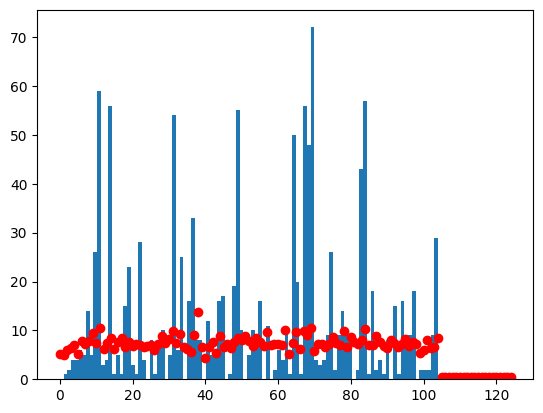

In [63]:
import math
from graphgps.layer.sparse_attention_layer import SparseAttention

from matplotlib import pyplot as plt

for layer_name in myFeatureExtractor.tokens.keys():
    token_list = myFeatureExtractor.tokens[layer_name]  # list of tensors, one for each graph
    label_list = myFeatureExtractor.labels[layer_name]  # list of tensors, one for each graph
    attn = myFeatureExtractor.attn_layers[layer_name]
    
    if isinstance(attn, SparseAttention):
        # [**, N, dim]
        x = token_list[0].unsqueeze(0)

        # [**, num_heads, N, kq_dim]
        queries = attn.split_heads(attn.MQs(x), small_dim=attn.kq_dim)
        keys = attn.split_heads(attn.MKs(x), small_dim=attn.kq_dim)
        # [**, num_heads, N, val_dim]
        values = attn.split_heads(attn.MVs(x), small_dim=attn.val_dim)

        # [**, num_heads, N, k]
        nearest_key_indices = attn.nearest_k_keys(queries, keys)
        print(nearest_key_indices.shape)

        # the k keys nearest to each query
        # [**, num_heads, N, k, kq_dim]
        nearest_keys = torch.gather(
            input=keys.unsqueeze(-2).expand(
                *keys.shape[:-1], attn.k, attn.kq_dim
            ),  # [**, num_heads, N, k, kq_dim]
            dim=-3,
            index=nearest_key_indices.unsqueeze(-1).expand(
                *nearest_key_indices.shape, attn.kq_dim
            ),  # [**, num_heads, N, k, kq_dim]
            # sparse_grad=True,
        )

        # [**, num_heads, N, k, kq_dim]
        queries_extended = queries.unsqueeze(-2).expand(
            *queries.shape[:-1], attn.k, attn.kq_dim
        )

        # [**, num_heads, N, k]
        largest_attention_weights = (queries_extended * nearest_keys).sum(
            -1
        ) / math.sqrt(attn.kq_dim)


plt.hist(nearest_key_indices[0][0].flatten(), bins=100)
plt.scatter(x=torch.arange(0,len(keys[0][0])), y=keys[0][0].detach().norm(dim=-1).flatten(), c='r')

In [87]:
import networkx as nx

def vis_mip_attn_graph(nearest_key_indices, largest_attention_weights, fake_nodes):
    """
    args:
        nearest_key_indices: [N, k]. nearest_key_indices[i][m]==j signifies there is an edge from j to i.
        fake_nodes: [N]. fake_nodes[i] == True signifies that node i is a fake node (i.e. has key norm 0)
    """

    N, k = nearest_key_indices.shape
    G = nx.DiGraph()
    for i in range(N):
        if not fake_nodes[i]:
            for m in range(k):
                G.add_edge(nearest_key_indices[i][m].item(), i, weight=largest_attention_weights[i][m].item())

    # get weights and normalize
    weights = nx.get_edge_attributes(G, 'weight')
    norm = plt.Normalize(vmin=min(weights.values()), vmax=max(weights.values()))
    # map weights to colors
    cmap = plt.cm.plasma
    edge_colors = [cmap(norm(weights[edge])) for edge in G.edges()]

    # draw the graph with edge colors
    fig, ax = plt.subplots(figsize=(10,10))
    pos = nx.spiral_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=.5)

    # Add a color bar to show the mapping of weights to colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for the colorbar
    plt.colorbar(sm, ax=ax, label='Edge Weight')

    plt.show()

    print(G.in_degree())
    print(G.out_degree())

    return G

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])
tensor([[-0.6307, -1

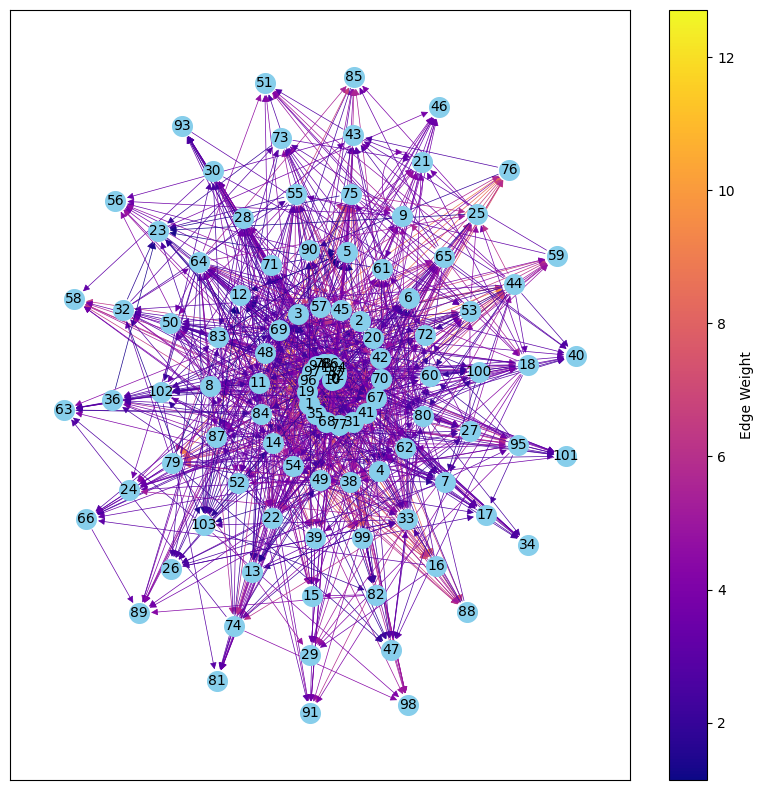

[(10, 10), (0, 10), (92, 10), (37, 10), (104, 10), (86, 10), (78, 10), (94, 10), (97, 10), (96, 10), (19, 10), (1, 10), (35, 10), (68, 10), (77, 10), (31, 10), (41, 10), (67, 10), (70, 10), (42, 10), (20, 10), (2, 10), (45, 10), (57, 10), (3, 10), (69, 10), (48, 10), (11, 10), (84, 10), (14, 10), (54, 10), (49, 10), (38, 10), (4, 10), (62, 10), (80, 10), (60, 10), (72, 10), (6, 10), (61, 10), (5, 10), (90, 10), (71, 10), (12, 10), (83, 10), (8, 10), (87, 10), (52, 10), (22, 10), (39, 10), (99, 10), (33, 10), (7, 10), (27, 10), (100, 10), (53, 10), (65, 10), (9, 10), (75, 10), (55, 10), (28, 10), (64, 10), (50, 10), (102, 10), (79, 10), (103, 10), (13, 10), (15, 10), (82, 10), (16, 10), (17, 10), (95, 10), (18, 10), (44, 10), (25, 10), (21, 10), (43, 10), (73, 10), (30, 10), (23, 10), (32, 10), (36, 10), (24, 10), (26, 10), (74, 10), (29, 10), (47, 10), (88, 10), (34, 10), (101, 10), (40, 10), (59, 10), (76, 10), (46, 10), (85, 10), (51, 10), (93, 10), (56, 10), (58, 10), (63, 10), (66,

In [88]:
fake_nodes = keys[0][0].norm(dim=-1) == 0
print(fake_nodes)
print(keys[0][0])

G = vis_mip_attn_graph(nearest_key_indices[0][0][:105], largest_attention_weights[0][0], fake_nodes)

{10: 26, 0: 0, 92: 15, 37: 33, 104: 18, 86: 18, 78: 14, 94: 16, 97: 18, 96: 9, 19: 23, 1: 1, 35: 14, 68: 48, 77: 9, 31: 54, 41: 12, 67: 56, 70: 14, 42: 5, 20: 3, 2: 0, 45: 17, 57: 11, 3: 2, 69: 58, 48: 19, 11: 59, 84: 57, 14: 56, 54: 9, 49: 55, 38: 8, 4: 4, 62: 10, 80: 9, 60: 6, 72: 3, 6: 6, 61: 4, 5: 4, 90: 8, 71: 4, 12: 3, 83: 43, 8: 14, 87: 2, 52: 5, 22: 28, 39: 8, 99: 2, 33: 25, 7: 5, 27: 7, 100: 2, 53: 10, 65: 20, 9: 5, 75: 26, 55: 16, 28: 10, 64: 50, 50: 10, 102: 9, 79: 10, 103: 11, 13: 4, 15: 1, 82: 2, 16: 5, 17: 1, 95: 9, 18: 15, 44: 16, 25: 8, 21: 1, 43: 5, 73: 4, 30: 5, 23: 4, 32: 6, 36: 2, 24: 0, 26: 1, 74: 9, 29: 0, 47: 1, 88: 4, 34: 0, 101: 2, 40: 0, 59: 2, 76: 2, 46: 0, 85: 1, 51: 0, 93: 1, 56: 0, 58: 0, 63: 1, 66: 1, 89: 1, 81: 0, 91: 0, 98: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0}
[(11, 59), (69, 58), (84, 57), (67, 56), (14, 56), (49, 55), (31, 54),

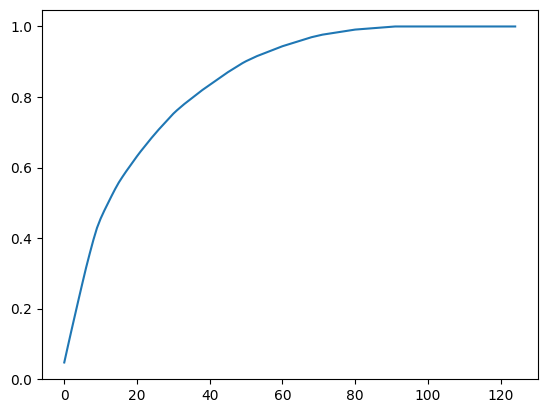

In [59]:
out_degrees = dict(G.out_degree())
print(out_degrees)
sorted_out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
print(sorted_out_degrees)

# plot a graph that shows how much the out_degrees are concentrated in the nodes with the highest out_degree
# x-axis: percentage of nodes, y-axis: percentage of out_degree

out_degrees = [out_degrees[i] for i in range(len(out_degrees))]
out_degrees = sorted(out_degrees, reverse=True)
print(out_degrees)
print(sum(out_degrees))

cumulative_out_degrees = [sum(out_degrees[:i+1]) for i in range(len(out_degrees))]
cumulative_out_degrees = [x/sum(out_degrees) for x in cumulative_out_degrees]
print(cumulative_out_degrees)

plt.plot(cumulative_out_degrees)
plt.show()

InDegreeView({0: 0, 1: 1})

(105, 2)
(105, 2)


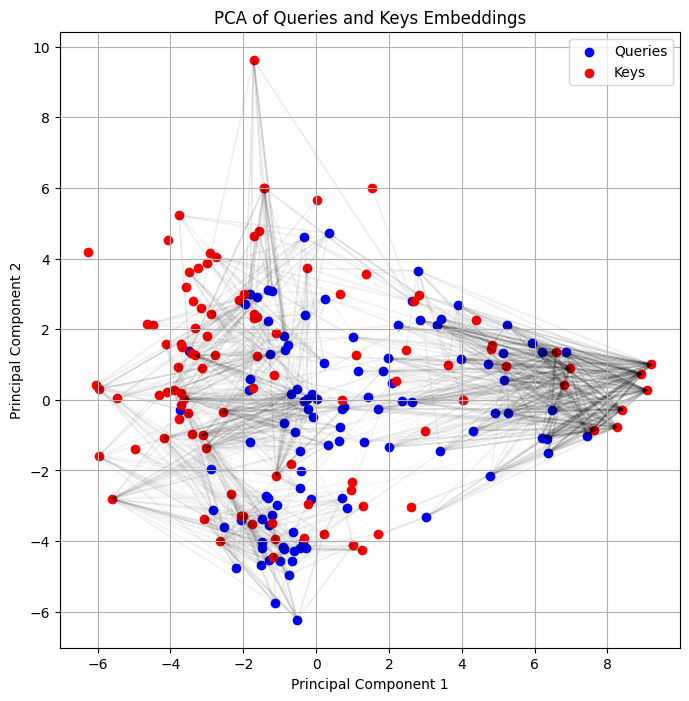

In [104]:
from sklearn.decomposition import PCA
import numpy as np

# Assume queries and keys are your input tensors of shape [N, D]
# Example:
# queries = torch.randn(100, 64)  # 100 embeddings of dimension 64
# keys = torch.randn(100, 64)     # 100 embeddings of dimension 64

# normalize largest_attention_weights[0][0] to get edge weights
edge_weights = largest_attention_weights[0][0].clone()
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Convert to NumPy arrays
queries_np = queries[0][0].detach().numpy()[:105]
keys_np = keys[0][0].detach().numpy()[:105]
nearest_key_indices_np = nearest_key_indices[0][0].numpy()[:105]

# Concatenate the queries and keys
embeddings = np.concatenate((queries_np, keys_np), axis=0)

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Split the PCA-transformed data back into queries and keys
queries_pca = embeddings_pca[:queries_np.shape[0], :]
keys_pca = embeddings_pca[queries_np.shape[0]:, :]
print(queries_pca.shape)
print(keys_pca.shape)

# Plot the PCA results
plt.figure(figsize=(8, 8))
plt.scatter(queries_pca[:, 0], queries_pca[:, 1], color='blue', label='Queries')
plt.scatter(keys_pca[:, 0], keys_pca[:, 1], color='red', label='Keys')
plt.title('PCA of Queries and Keys Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Draw arrows
for i in range(keys_pca.shape[0]):
    for m in range(nearest_key_indices_np.shape[1]):
        j = nearest_key_indices_np[i, m]
        plt.arrow(
            x=queries_pca[i, 0], y=queries_pca[i, 1],
            dx=keys_pca[j, 0] - queries_pca[i, 0], dy=keys_pca[j, 1] - queries_pca[i, 1],
            color='black', alpha=0.2 * edge_weights[i, m].item()
        )


plt.legend()
plt.grid(True)
plt.show()

/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(105, 2)
(105, 2)


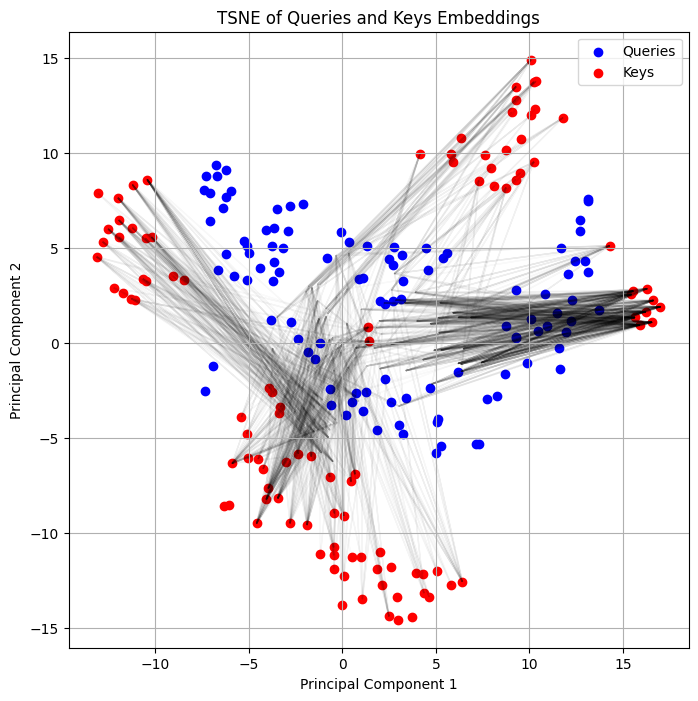

In [107]:
from sklearn.manifold import TSNE
import numpy as np

# Assume queries and keys are your input tensors of shape [N, D]
# Example:
# queries = torch.randn(100, 64)  # 100 embeddings of dimension 64
# keys = torch.randn(100, 64)     # 100 embeddings of dimension 64

# normalize largest_attention_weights[0][0] to get edge weights
edge_weights = largest_attention_weights[0][0].clone()
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Convert to NumPy arrays
queries_np = queries[0][0].detach().numpy()[:105]
keys_np = keys[0][0].detach().numpy()[:105]
nearest_key_indices_np = nearest_key_indices[0][0].numpy()[:105]

# Concatenate the queries and keys
embeddings = np.concatenate((queries_np, keys_np), axis=0)

# Apply PCA to reduce dimensions to 2D
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the PCA-transformed data back into queries and keys
queries_tsne = embeddings_tsne[:queries_np.shape[0], :]
keys_tsne = embeddings_tsne[queries_np.shape[0]:, :]
print(queries_tsne.shape)
print(keys_tsne.shape)

# Plot the PCA results
plt.figure(figsize=(8, 8))
plt.scatter(queries_tsne[:, 0], queries_tsne[:, 1], color='blue', label='Queries')
plt.scatter(keys_tsne[:, 0], keys_tsne[:, 1], color='red', label='Keys')
plt.title('TSNE of Queries and Keys Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Draw arrows
for i in range(keys_tsne.shape[0]):
    for m in range(nearest_key_indices_np.shape[1]):
        j = nearest_key_indices_np[i, m]
        plt.arrow(
            x=queries_pca[i, 0], y=queries_pca[i, 1],
            dx=keys_tsne[j, 0] - queries_pca[i, 0], dy=keys_tsne[j, 1] - queries_pca[i, 1],
            color='black', alpha=0.2 * edge_weights[i, m].item()
        )


plt.legend()
plt.grid(True)
plt.show()

array([[-1.3503120e+00, -2.6920779e+00],
       [-1.1446744e-01, -2.8154767e+00],
       [-1.2700746e+00, -4.5306916e+00],
       [ 2.0774260e+00,  5.4448932e-01],
       [-7.8135318e-01,  1.6186454e+00],
       [ 6.3725924e-01, -1.1259946e+00],
       [-1.8098649e+00, -1.1569797e+00],
       [ 2.3556910e+00,  5.8884542e-02],
       [-8.6776125e-01,  1.8420188e+00],
       [-3.0540937e-01, -1.2254201e-01],
       [ 1.7102467e+00, -3.0641237e-01],
       [-2.5304338e-01, -4.2112780e+00],
       [-4.0832877e-01, -1.9918108e+00],
       [ 1.1472456e+00,  7.8786135e-01],
       [-5.9990829e-01, -3.7235341e+00],
       [ 3.8859069e+00,  2.7274716e+00],
       [ 5.9173341e+00,  1.6083951e+00],
       [-2.8160753e+00, -3.1192584e+00],
       [ 7.4311531e-01, -3.8490510e-01],
       [ 7.4586072e+00, -1.0490401e+00],
       [-5.5819571e-01, -9.1974515e-01],
       [ 3.2942677e-01,  4.6966777e+00],
       [ 5.2910938e+00, -3.2766265e-01],
       [-2.3138641e-01,  3.0744085e-02],
       [ 1.84830

In [109]:
for name, submodule in model.named_modules():
    num_params = sum(p.numel() for p in submodule.parameters())
    print(f"Submodule: {name}, Number of parameters: {num_params}")

Submodule: , Number of parameters: 209535
Submodule: encoder, Number of parameters: 680
Submodule: encoder.node_encoder, Number of parameters: 600
Submodule: encoder.node_encoder.encoder1, Number of parameters: 240
Submodule: encoder.node_encoder.encoder1.encoder, Number of parameters: 240
Submodule: encoder.node_encoder.encoder2, Number of parameters: 360
Submodule: encoder.node_encoder.encoder2.linear_encoder_eigenvec, Number of parameters: 360
Submodule: encoder.edge_encoder, Number of parameters: 80
Submodule: encoder.edge_encoder.encoder, Number of parameters: 80
Submodule: layers, Number of parameters: 206805
Submodule: layers.0, Number of parameters: 41361
Submodule: layers.0.local_model, Number of parameters: 8481
Submodule: layers.0.local_model.A, Number of parameters: 1640
Submodule: layers.0.local_model.B, Number of parameters: 1640
Submodule: layers.0.local_model.C, Number of parameters: 1640
Submodule: layers.0.local_model.D, Number of parameters: 1640
Submodule: layers.0.

: 